# DESCRIPTIVE AND INFERENTIAL STATISTICS
<a id="begining_stats"></a>

@author: Régis Gbenou <br>
@email: regis.gbenou@outlook.fr

Recall that the aim of this project is to estimate the financial influence that a given genre can have on the generated money by a film.
I will use the previous data transformation [1_preprocessing.ipynb](1_preprocessing.ipynb#begining_preprocessing) and conduct an inference study.

## 1 LIBRARIES

In [1]:
import analyticalFunctions                           # Module containing function for inferences and predictions.
import itertools                                     # Library providing iterative functions.
import matplotlib.pyplot as plt                      # Library to plot graphics.
import numpy as np                                   # Library for matrix computation.
import pandas as pd                                  # Library for data manipulation.
import re                                            # Library for regex expression.
import seaborn as sns                                # Library to display graphics and make some basic statistics.
sns.set(style="ticks", color_codes=True)
import statsmodels.api as sm                         # Library for statistical models.
import statsmodels.stats.api as sms                  # Library for statistical models.
import statsmodels.formula.api as smf                # Library to use formula expression in statistical models.
from statsmodels.stats.outliers_influence\
    import variance_inflation_factor, OLSInfluence   # Function to evaluate multicolinearity of columns in a matrix.
from statsmodels.stats.stattools\
    import durbin_watson, medcouple                  # Funcitons that evalue respectively the autocorrelation (AR(1)) in
# a time serie and the skewness (asymmetry) of a distribution.
from statsmodels.graphics.tsaplots\
    import plot_acf                                  # To plot AutoCorrelation Function (ACF)
import scipy.stats as sci                            # Library of computation interest.
import sklearn                                       # Library of machine Learning Model
from sklearn.base import BaseEstimator,\
    RegressorMixin                                   # Respectively class for all estimator and regressor of Scikit-Learn
from sklearn.ensemble import  RandomForestRegressor  # Module to access to RandomForest function.
from sklearn import linear_model                     # Module to access to Linear Regression, and other regularized functions.
from sklearn.model_selection import KFold,\
cross_validate, GridSearchCV                         # Functions helping in the selection of features or hyperparameters
from sklearn.neighbors import KNeighborsRegressor    # Module to access to KNeighbors algorithm.
from sklearn.pipeline import Pipeline, make_pipeline # Module to produce pipeline estimators.
from sklearn.preprocessing import PowerTransformer   # Module to make Power Transformation.
import time                                          # Library to access to the computer clock.as 

## 2 Functions

In [2]:
from analyticalFunctions import (
    plot_fct,
    boxPlot_fct,
    ols_summary_fct,
    find_bestHyperparameters,
    mse_r2_score_fct,
    find_bestModel_fwd_bwd,
    compute_rmse_r2
)

## 3 SCRIPT

Variable summary: 
- <a id="CWG_std"></a> **CWG_std**: Cumulative Worldwide Gross (standardized: converted in US dollars), the variable having as values the money generated by each available movie. 
- <a id="Budget_std"></a> **Budget_std**: Budget (standardized: converted in US dollars), this variable contains the money invested to make and promote the each available movie.  
- <a id="nbre_note"></a> **nbre_note**: Number of note, this variable contains the number of votes stored by IMDB for each available movie, in this study it will only used in the inference part, somewhat it will be considered as a measure of a movie popularity. 
- <a id="note"></a> **note**: Note, tis variable contains the weighted rate provided by IMDB to sum up the opinion of the professional critics and the IMDB community about the movie, it will only used in the inference part.
- <a id="runtime_min"></a> **runtime_min**: This variable contains the duration in minutes of each available movie.
- <a id="year"></a> **year**: This variable contains the release year of each available movie.

Other variables will be explained when they will be used, or have a name sufficiently explicit.

### 3.1 Description 
<a id='description_id'></a>

In [3]:
# Collecting all data transformed by the 1_preprocessing.ipynb script.
df0 = pd.read_csv('../2_data/2_transformed/1_processedData.csv', sep=';')
frame = df0.copy()
frame.columns

Index(['title', 'genre', 'year', 'country', 'runtime_min', 'note', 'nbre_note',
       'Budget', 'Cumulative_Worldwide_Gross', 'Budget_curr',
       'Cumulative_Worldwide_Gross_curr', 'Budget_std', 'CWG_std', 'Directors',
       'Writers', 'Stars'],
      dtype='object')

The following [scatter matrix from the seaborn library](https://seaborn.pydata.org/examples/scatterplot_matrix.html) allows to plot one variable against each other and
to display the linear regression line therewith to detect presence of linearity between the variables.

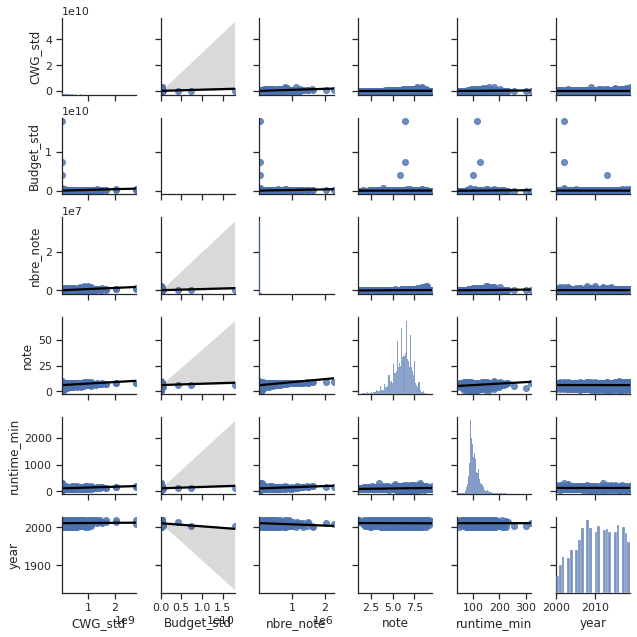

In [4]:
# Numerical analysis
col_list = ['CWG_std', 'Budget_std', 'nbre_note', 'note', 'runtime_min', 'year']
sns.pairplot(frame[col_list], kind='reg', height=1.5, plot_kws={'line_kws':{'color':'black'}})
plt.show()

For the diagonal graphs, at the emplacement (j,j) I left the histogram of the $j^{th}$ variable.
Regarding the elements of the diagonal matrix, that is the histograms, we can notice that the variables 'Budget_std',
[CWG_std](#CWG_std) and 'nbre_note' have their data crushed to the left. It is a strong indicator of the presence of
outliers.<br>
Then we will inspect their values thanks to the function 
[plot_fct](analyticalFunctions.py#L48).

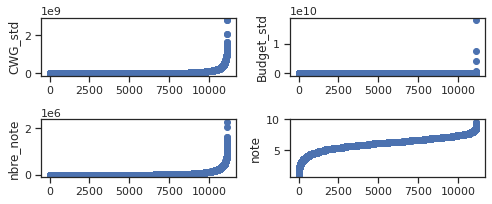

In [5]:
plot_fct(frame, col_list[:4])

I applied the [plot_fct](analyticalFunctions.py#L48) to the 4 numerical variables [CWG_std](#CWG_std), [Budget_std](#Budget_std), [nbre_note](#nbre_note) and [note](#nbre_note).<br>
The first three have an exponential form, whereas the last one has a S shape, those 2 kinds of shape are explained by the distribution of the values.<br>
Now use the [boxPlot_fct](analyticalFunctions.py#L99) function, this function colors in red the points that are ahead the space delimited by the whiskers.

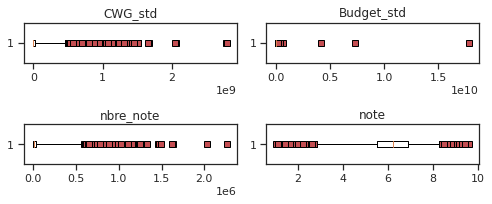

In [6]:
boxPlot_fct(frame[col_list[:4]])

Observing the graphs provided by [boxPlot_fct](analyticalFunctions.py#L99) I understood that the exponential shape is the consequence of
an important quantity of very large values.<br>
And eventually the S-shape is explained by the presence of an approximate balanced number of  outliers between
very small and very large values.

Thus I will apply the natural logarithm function to the first three variable, the variable "note" will be left
unchanged because there is not obvious method to improve the data of [note](#note).

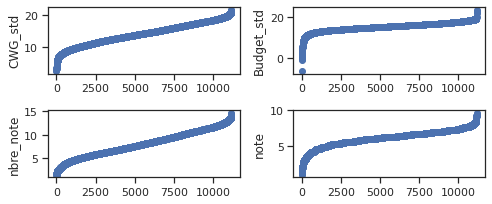

In [7]:
frame = df0.copy()
col_transf = ['CWG_std', 'Budget_std', 'nbre_note']

frame.loc[:, col_transf] = np.log(frame.loc[:, col_transf])
plot_fct(frame, col_list[:4], size=(7, 3))

The impact of outliers has been reduced, we will observe the consequence more precisely with the box plots.

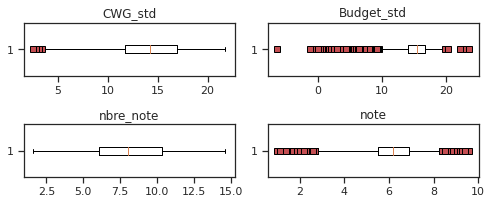

In [8]:
boxPlot_fct(frame[col_list[:4]])

The variable [CWG_std](#CWG_std) has a better look, and seems rather containing very small values, that is corresponds to
very low economic revenues. The variable [nbre_note](#nbre_note) seems really having been improved. But the variable
[Budget_std](#Budget_std), which is the last variable having been subjected to log transformation, have been slightly
improved, there are lot of very small values. It is due to the presence of very low budget, we will see it
with true values.

In [9]:
df0[['Budget_std', 'Budget', 'Budget_curr']].sort_values(
    by='Budget_std').head(15)

,Budget_std,Budget,Budget_curr
9373,0.001716,10.0,PYG
10348,0.277138,900.0,COP
8640,0.696324,44.0,INR
11065,1.062306,40.0,ARS
10839,1.436680,100.0,INR
4346,1.680720,10.0,TRL
10583,1.879408,120.0,INR
9839,1.965988,17.0,NOK
10401,2.205558,22.0,VEB
9321,3.021085,200.0,INR


Some budget values are very low, and added to this they are initially linked to weak currency weight compared with the US 
dollars. This last fact reduces again the amount of these budget values when they are converted in dollars. Then in the third line of the above table, a low budget value of INR $44$ begins lower in dollars: $\$ 0.69$.

In [10]:
perc = .15 # percentile
dct = {k:[int(round(df0[df0.Budget_curr==k].Budget.quantile(perc))), df0[df0.Budget_curr==k].shape[0]] for k in list(set(df0.Budget_curr))}
dct = dict(sorted(dct.items(), key=lambda x: x[1][0]))
print(f'For the {int(perc*100)}th percentile:\n')
for i,k in enumerate(dct):
    if i==20:
        break
    else:
        print(k, dct[k])
print(f'\nThe total number of currencies: {len(dct)}')

For the 15th percentile:

PYG [10, 1]
TRL [4540, 57]
GEL [50000, 1]
VEB [75006, 6]
NZD [118000, 24]
GBP [200000, 262]
BGL [204000, 5]
MYR [256500, 36]
LVL [299600, 5]
CHF [360000, 13]
AED [363000, 2]
ARS [443500, 36]
RON [488221, 3]
BRL [500000, 109]
EUR [500000, 2189]
AUD [650000, 98]
BOB [800000, 1]
ROL [900000, 1]
SGD [950000, 31]
PEN [950000, 1]

The total number of currencies: 68


In [11]:
perc = .15 # percentile
dct = {k:[int(round(df0[df0.Budget_curr==k].Budget_std.quantile(perc))), df0[df0.Budget_curr==k].shape[0]] for k in list(set(df0.Budget_curr))}
dct = dict(sorted(dct.items(), key=lambda x: x[1][0]))
print(f'For the {int(perc*100)}th percentile:\n')
for i,k in enumerate(dct):
    if i==20:
        break
    else:
        print(k, dct[k])
print(f'\nThe total number of currencies: {len(dct)}')

For the 15th percentile:

PYG [0, 1]
TRL [1356, 57]
NPR [13780, 1]
VEB [17442, 6]
GEL [19134, 1]
ARS [21578, 36]
KZT [26010, 1]
JPY [55787, 25]
IRR [60348, 4]
COP [74267, 6]
MYR [75960, 36]
NZD [81184, 24]
AED [98843, 2]
ISK [100769, 9]
BOB [114778, 1]
RON [115617, 3]
ZAR [145739, 41]
PKR [175894, 6]
BRL [181479, 109]
KRW [213466, 38]

The total number of currencies: 68


I created the "dct" dictionary having as keys the currencies and as values 2-length lists, each list has its
first item corresponding to the 10th percentile of the variable [Budget_std](#Budget_std). And the second item is the number of movies having a budget
associated with the given currency.<br>
This dictionary is sorted by the first element of its lists, and we can notice that since the third line we exceed $\$10,000$.</br>

I will choose a minimum budget of $\$13,000$, this choice is arbitrary, with
some search I found that the more expensive movie in the history is Pirates of the Caribbean: On Stranger
Tides with a budtget of $\$379M$, see [wikipedia](https://en.wikipedia.org/wiki/List_of_most_expensive_films#Films).

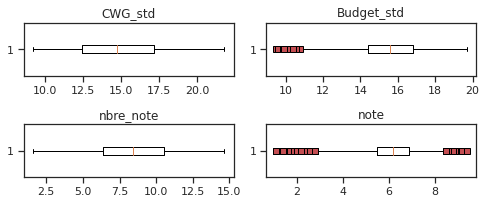

In [12]:
frame = df0[(df0.Budget_std > 1.3e4) & (df0.Budget_std < 3.8e8) & (df0.CWG_std>1e4)].copy()
frame.loc[:, col_list[:3]] = np.log(frame.loc[:, col_list[:3]])
boxPlot_fct(frame[col_list[:4]])

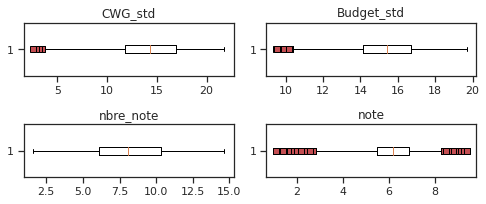

In [13]:
frame = df0[(df0.Budget_std > 1.3e4) & (df0.Budget_std < 3.8e8)].copy()
frame.loc[:, col_list[:3]] = np.log(frame.loc[:, col_list[:3]])
boxPlot_fct(frame[col_list[:4]])

[Budget_std](#Budget_std) has become more acceptable, there are always many outliers according to the thumb rule of
[medcouple](https://en.wikipedia.org/wiki/Box_plot#Variations). However this thumb rule is not a robust
method, so seeking to remove all outliers according this rule presents certernly drawbacks.

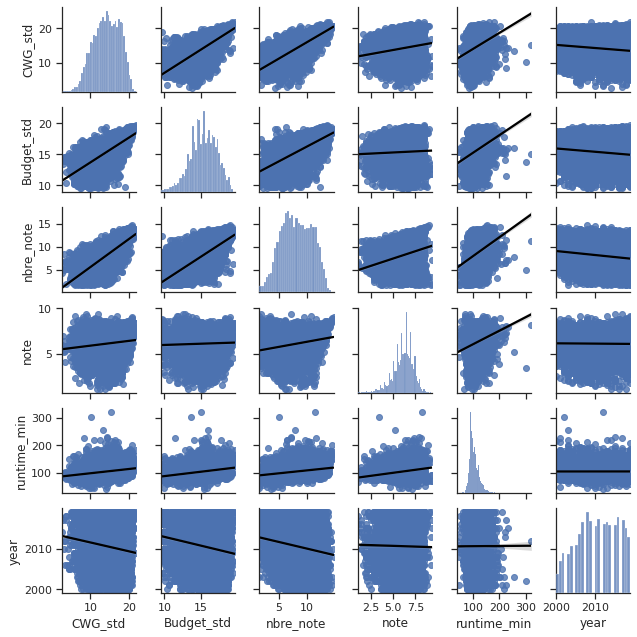

In [14]:
sns.pairplot(frame[col_list], height=1.5, kind='reg', plot_kws={'line_kws':{'color':'black'}})
plt.show()

Now the data are improved, I should think about, among them, which ones I will keep in my study.

I recall that the response is [CWG_std](#CWG_std) so we will respectively observing [Budget_std](#Budget_std), [nbre_note](#nbre_note), [note](#note) and [year](#year). Then we must focus on the first line where 'CWG_std' is in the ordinate.<br>
'Budget_std', 'nbre_note' have a positive correlation with 'CWG_std', whereas the 'note' variable has a moderate positive correlation with it. The 'runtime_min' variable has no relationship with the response, eventually the 'year' have weak correlation with 'CWG_std'.<br>

From this scatter matrix we are understanding that:
- the money generated by a movie increases when the budget and the popularity is high, it not very surprising.
- it seems that the note given at a movie is less relevant to estimate the money generated than the number of votes (the popularity), after all if a movie receives bad ratings from the critics but the people for one or another reason go watching it, the movie make money.
- the duration of a movie has no effect on the money generated even on the budget.
- the budget and the popularity are correlated, we could emit the hypothesis that for create popularity around a movie famous people are needed, but for hiring these people significant amount of money is needed.
- another interesting fact is that there seems to be a trend of generated money, budget, and popularity decreasing. When we observe the last column see that this phenomenon can be correlated with a presence of more low budget movie. This last point could be compared with the emergence of streaming platform, it deserves further consideration but is ahead of my scope study.

In conclusion, 'Budget_std' and 'nbre_note' seems to be the principal relevant variables, but are correlated, the 'runtime_min' variable seems to be the less relevant explanatory variables.

I will pass to the quantitative part of the study, 

In [15]:
df01 = df0[(df0.Budget_std > 1.3e4) & (df0.Budget_std < 3.8e8)].drop(
    columns=['country', 'Budget', 'Cumulative_Worldwide_Gross_curr',
                 'Cumulative_Worldwide_Gross']).copy()
df01.to_csv('../2_data/2_transformed/2_data_reducedBudget', sep=';', index=False)
dummyFrame = frame["genre"].str.get_dummies()  # Dummy table creation from a serie containing strings of words seperated by a comma.
df = df01.join(dummyFrame)
df.to_csv('../2_data/2_transformed/2_dataWithoutDummyCoding.csv',
          sep=';', index=False)

<a id='mse_r2_score_fct'></a>

### 3.2 Inferences 
<a id='inferences'></a>

The aim of this part is to assess the influence of the genre..

In [16]:
df00 = pd.read_csv('../2_data/2_transformed/2_data_reducedBudget', sep=';')

I am interesting in knowing how the explanatory variables influence the response [CWG_std](#CWG_std), I will only conduct regression analysis in this part study. I want finding
an estimate $\hat{f}$ of $f$ considering that our data is of the form $\mathbf{CWG_{std}} =
f(\mathbf{X})$. For this we have to estimate $\mathbb{E}(\mathbf{CWG_{std}}|\mathbf{X})$ the expected value of
$\mathbf{CWG_{std}}$ conditioning on $\mathbf{X}$ ant then understanding how the predictive variables present in
$\mathbf{X}$ influence the response $\mathbf{CWG_{std}}$.<br>

We will test different approaches in order to find the best suited model.
- Firstly we will considering the "semi-original" model which have been slightly modified, in removing some large Budget values.
- Secondly from our previous study we will assess the quality of a log transformation model.
- Thirdly I will use a model in which I will remove influential values, meaning outliers and leverages, that I have potentially not be able to detect.  

In [17]:
df = df00.loc[:,['CWG_std', 'Budget_std', 'nbre_note', 'note', 'runtime_min', 'year', 'genre']].copy()
thresh = 15 # Threshold from which all the genres that have an occurence in the data lower than this threshold will be put in the 'OTHER' category. It is for regression purpose therewith to have enough observation to estimate parameters.
s = pd.get_dummies(df.genre, drop_first=True).sum().sort_values(ascending=False) # serie that has the all the genres, except the first one, as index and the occurence associated with the genres as values.  
other_genres = list(s[s<thresh].index) # contains all the genres from <s> having an occurence lower than <thresh>
# other_genres = [k for k in other_genres]
df.genre.where(~df.genre.isin(other_genres), 'OTHER', inplace=True) # Replaces all values values from the genre column that are present in <other_genres> by 'OTHER'.
n0, n1 = df00.genre.unique().shape[0], df.genre.unique().shape[0] 
print(f"There are {n1-1}/{n0} genres that are considered.\n\n\nSummary of the data removed:\n\
{df00[df00.genre.isin(other_genres)].loc[:, ['CWG_std', 'Budget_std']].describe()}")
print(f"\n\n\nSummary of the data conserved:\n\
{df00[~df00.genre.isin(other_genres)].loc[:, ['CWG_std', 'Budget_std']].describe()}")

There are 130/509 genres that are considered.


Summary of the data removed:
            CWG_std    Budget_std
count  1.381000e+03  1.381000e+03
mean   3.297578e+07  1.595484e+07
std    1.047187e+08  2.816709e+07
min    9.100000e+01  1.378043e+04
25%    1.230930e+05  1.500000e+06
50%    1.406538e+06  5.000000e+06
75%    1.801210e+07  1.750000e+07
max    1.657139e+09  2.600000e+08



Summary of the data conserved:
            CWG_std    Budget_std
count  9.619000e+03  9.619000e+03
mean   4.542709e+07  1.783234e+07
std    1.382962e+08  3.376757e+07
min    1.300000e+01  1.318464e+04
25%    1.277260e+05  1.400000e+06
50%    1.687000e+06  5.000000e+06
75%    2.372623e+07  1.800000e+07
max    2.797801e+09  3.560000e+08


#### Scale transformation
Here we will scale the data to get money amount in millions of dollars.

In [18]:
df_scale = df.copy()
df_scale.loc[:, ['CWG_std', 'Budget_std']] = df_scale.loc[:, ['CWG_std', 'Budget_std']]*1e-6 # scaling

To begin I will use the GLM (Generalized Linear Model) approach to make the less assumption about the
response distribution, with this model I only assume that each observation from $\mathbf{CWG_{std}}$ is drawn from a particular distribution of the exponential family that regroups normal, poisson, gamma distribution among others.</br>
With GLM we will study the following equation $\mathbb{E}(\mathbf{CWG_{std}}|\mathbf{X})=g^{-1}(\mathbf{X\beta})$ 
considering $\mathbf{CWG_{std}}|\mathbf{X}$ having an exponential distribution and $g$ an invertible function called "link function".

I will use my function "find_bestHyperparameters" to identify more precisely the most likely
distribution among a gaussian distribution, a poisson distribution, a gamma distribution and a Tweedie 
distribution. Even though that the previous log-transformation seems to show a linear function between the response and the principal relevant predictors.
The [find_bestHyperparameters](analyticalFunctions.py#L270) function is based on the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
function from the scikit-learn package, it allows to find the hyperparameters which will reduce the most the
MSE.<br>

Below there is a script thanks which I can apply scikit-learn functions on statsmodels function inspired from
[StackOverflow post](https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible).

In [19]:
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper_glm_reg(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True, family=None, L1_wt=0, alpha=0):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.family = family
        self.L1_wt = L1_wt
        self.alpha = alpha
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        if self.family:
            self.model_ = self.model_class(y, X, family=self.family)
        else:
            self.model_ = self.model_class(y, X)
        if self.alpha:
            results_ols = self.model_.fit()
            self.results_ = self.model_.fit_regularized(
                L1_wt = self.L1_wt,
                alpha = self.alpha,
                start_params = results_ols.params)
        else:
            self.results_ = self.model_.fit()
            
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [20]:
best_hyperparameters_glm = find_bestHyperparameters(
    df = df_scale.drop(columns=['genre']),
    name_y = 'CWG_std',
    estimator = SMWrapper_glm_reg(sm.GLM),
    parameters = {'family':[sm.families.Gaussian(),
                            sm.families.InverseGaussian(),
                            sm.families.Binomial(),
                            sm.families.Poisson(),
                            sm.families.NegativeBinomial(),
                            sm.families.Gamma(),
                            sm.families.Tweedie(),
                           ]},
    k_cv=5,
    n_jobs=6,
    graph=False
)

For SMWrapper_glm_reg(family=<statsmodels.genmod.families.family.Gaussian object at 0x7ff591519160>,
                  model_class=<class 'statsmodels.genmod.generalized_linear_model.GLM'>) we have MSE:-5351 +-684
For SMWrapper_glm_reg(family=<statsmodels.genmod.families.family.Gaussian object at 0x7ff591519160>,
                  model_class=<class 'statsmodels.genmod.generalized_linear_model.GLM'>) we have R^2:70.4 +-0.5
The above results are estimated by cross_validate() and may slightly differ from those estimated by GridSearchCV()
Elapsed time: 0h 0min 2s


As I expected the best GLM fit is obtained when the distribution of the response conditioning on the predictors, $\mathbf{CWG_{std}}|\mathbf{X}$, is considered as a gaussian distribution. Then the error term is better modeling as being normally distributed, and the link between the response and the predictors seem is better fitted with the identity link function. 

I can then rightly use an OLS (Ordinary Least Squares) method which provides more information about the modeling than
GLM. I will use my "ols_summary_fct" function that provides complementary information with graphics, the MSE 
estimate value, the VIF(Variance Inflation Factor), ...etc.

In [21]:
ols_summary_fct(
    dfo=pd.get_dummies(df_scale, columns=['genre'], drop_first=True),
    name_y='CWG_std',
    summary=False,
    graph=False,
    vif=False
)


R2_adj: 71.7%

LOG-LIKELIHOOD:  -6.25e+04

Fscore:  207.3

Fpvalue:  0.0

AIC:  1.25e+05

BIC:  1.26e+05

CONDITION NUMBER:  4.97e+07

RESIDUAL MSE:  5129.8

HOMOSCEDASTICITY ASSUMPTION
Breush-Paga test:	Fscore:12.9, Pval=0.0

INDEPENDENCY ASSUMPTION
Autocorrelation of the first order:
The Durbin-Watson test result: 1.9


Regarding the [ols_summary_fct](analyticalFunctions.py#L147) it seems that the OLS model explains $71.7\%$ (Adj. R-squared) of our model,
that is good, but when we observe the estimated MSE it is high: $5129.8$ so approximately we the model makes on average error of $\$71 600$ in prediction, that is huge.

Maybe some predictors have to be removed, we will use a [backward stepwise selection](https://quantifyinghealth.com/stepwise-selection/)
in order to remove variables that do not help the model.

The model without any predictor (forward) or the one with all predictors (backward) has been treated.
Iteration number: 135.
Model with :135/135 predictors. 
Elapsed time: 0h 0min 24s.
Iteration number: 134.
Model with :134/135 predictors. 
Elapsed time: 0h 0min 24s.
Iteration number: 133.
Model with :133/135 predictors. 
Elapsed time: 0h 0min 24s.
Iteration number: 132.
Model with :132/135 predictors. 
Elapsed time: 0h 0min 23s.
Iteration number: 131.
Model with :131/135 predictors. 
Elapsed time: 0h 0min 22s.
Iteration number: 130.
Model with :130/135 predictors. 
Elapsed time: 0h 0min 21s.
Iteration number: 129.
Model with :129/135 predictors. 
Elapsed time: 0h 0min 20s.
Iteration number: 128.
Model with :128/135 predictors. 
Elapsed time: 0h 0min 19s.
Iteration number: 127.
Model with :127/135 predictors. 
Elapsed time: 0h 0min 18s.
Iteration number: 126.
Model with :126/135 predictors. 
Elapsed time: 0h 0min 18s.
Iteration number: 125.
Model with :125/135 predictors. 
Elapsed time

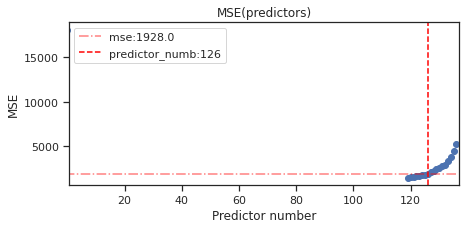

In [22]:
results_bwd_ols = find_bestModel_fwd_bwd(
    df=df_scale,
    name_y = 'CWG_std',
    mode='backward',
    estimator=linear_model.LinearRegression(),
    cols_categ=['genre'],
    nrows_thresh=8500,
    thresh=5,
    n_jobs=6)

[find_bestModel_fwd_bwd](analyticalFunctions.py#L505) makes forward or backward stepwise selection, I have designed it to at each step
making a dummy coding while avoiding dummy trap. The function provide also graphic, for a backward selection
it will identify the model from which our mse reduction rate is below "thresh" here $5\%$.
The forward or stepwise selection can be very time consuming, added to this the embedded dummy coding in the
function reduce or increase the number of observation depending if we have selected "backward" or "forward"
selection. So I also putted an argument "nrows_thresh" in order to stop the algorithm as soon as the model
contains less(backward) or more(forward) than "nrows_thresh" observations.<br>

The first model for which we get a decrease of less than $5\%$ is the model containing  predictors.<br>
But which ones? <br>
The following cell will retrieve the corresponding predictors.

In [23]:
comb = results_bwd_ols['best_models'][results_bwd_ols['best_models'].predictorNumb==126].combinations.values[0]
col_name = list(pd.get_dummies(df_scale.iloc[:, 1:], columns=['genre'], drop_first=False))
cn = [col_name[i] for i in comb]
cn_g = [k.split('_')[1:][0] for k in cn if k.split('_')[0]=='genre']
cn_g_not = [k for k in cn if k.split('_')[0] != 'genre']
assert len(cn) == len(cn_g + cn_g_not)
d_bwd_ols = pd.get_dummies(df_scale[df_scale.genre.isin(cn_g)].loc[:, ['CWG_std', 'genre']+cn_g_not],
                   columns=['genre'], drop_first=True)
dropped_level = (df_scale[df_scale.genre.isin(cn_g)].sort_values(by='genre')).genre.iloc[0]
print(f'Dropped level: {dropped_level}') # To know which level has been in order to avoid the dummy trap.

Dropped level: Action


There are: 8814 observations.

R2_adj: 66.0%

LOG-LIKELIHOOD:  -4.56e+04

Fscore:  138.0

Fpvalue:  0.0

AIC:  9.14e+04

BIC:  9.23e+04

CONDITION NUMBER:  4.08e+07

RESIDUAL MSE:  1832.8

HOMOSCEDASTICITY ASSUMPTION
Breush-Paga test:	Fscore:14.5, Pval=0.0

INDEPENDENCY ASSUMPTION
Autocorrelation of the first order:
The Durbin-Watson test result: 2.0


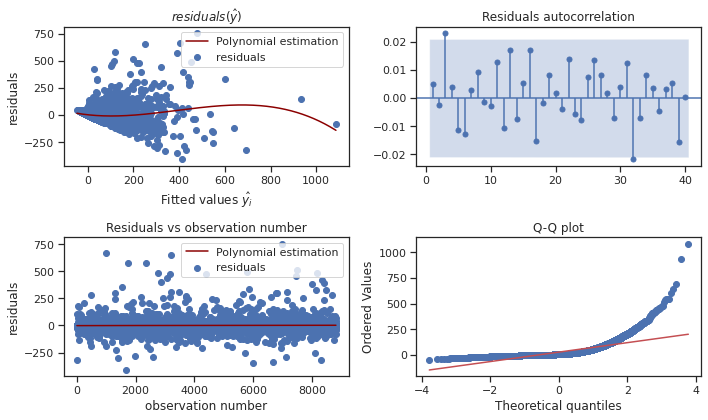

In [24]:
print(f'There are: {d_bwd_ols.shape[0]} observations.')
ols_summary_fct(d_bwd_ols, name_y='CWG_std', summary=False, vif=False, graph=True, size=(10, 6))

Despite the improvement of the log-likelihood and MSE, and we have lost {{df_scale.shape[0]-d_bwd_ols.shape[0]}} observations that is no neglible this model is good we will keep it in mind.

The [ols_summary_fct](analyticalFunctions.py#L147) function provides many information about the Ordinary Least Squares (OLS) regression, as
- the summary of the library statsmodels 
- the Mean of Square Error (MSE)
- graphs about the residuals.

For a multiple linear regression of the form : $y=\beta_{0}+\displaystyle\sum_{j=1}^{p}\beta_{j}x_{\bullet j}$ we make a [F-test](https://en.wikipedia.org/wiki/F-test#Regression_problems)
in order to decide if at least one feature have an impact on the response. The [p-value](https://en.wikipedia.org/wiki/P-value#General)
is equal to $0$, then the test is significant, furthermore the F-score is good: $138$, this 2 indicators
made me confident about the model.

Then I looked to the Mean Squared Error (MSE), it is of $\$1832$, thus the real 'CWG_std' are different
in average of $\$43000$ from our prediction fitted it is high, I think this can be improved.

I will then observe more precisely the 4 diagnostic plots, in the first line, the
left graph shows the residuals against the fitted data it allows to see the residual means tendency depending on the fitted values. At the left the plot of the autocorrelation function.<br>
In the last line, the right graph shows residuals depending on their index, therewith to notice a potential pattern which can indicate a problem in our modeling.
The last graph is called a QQ plot, it shows on the same graph a line of passing through the quantiles from a normal simulated data, and a courbe which is form the real data.

Thanks to the graphs I detected 3 main problems:
- Heteroscedasticity,in the top left graph the variance of the residuals increases as the fitted values increase, the polynomial approximation (red curve) help us to see the tendency of the residual mean.
- Non normal distribution of the residuals thanks to the bottom right plot, if residuals were normally distributed they would be near of teh red line.
- Multicolinearity between the independent variables, the VIF values are displayed below the graphs and 'year', 'runtime_min' as well as 'note' have a large value, this is a strong sign of colinearity.


To reduce the heteroscedasticity one idea can be transform data, in the above searches, I have seen that a log transformation applied on the response 'CWG_std',
and the features 'Budget_std' and 'nbre_note', thus I decided to transform the data.

#### Dropping influential points

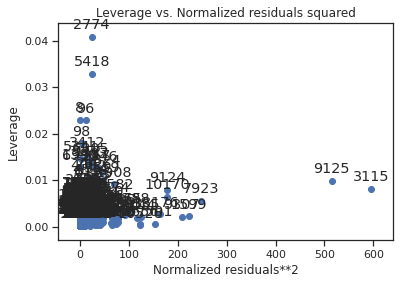

In [25]:
y_scale, X_scale = df_scale.iloc[:, 0], df_scale.iloc[:, 1:-1]
result_ols = sm.OLS(y_scale, X_scale).fit()
sm.graphics.plot_leverage_resid2(result_ols)
plt.show()

In [26]:
infl = OLSInfluence(result_ols)

df_infl = pd.DataFrame(dict(
    hat_diag = infl.hat_matrix_diag,
    resid = sci.zscore(infl.resid)),
    index = infl.results.model.data.row_labels                  
).sort_values(by='hat_diag', ascending=False)

highLever = 2*(result_ols.df_model+1)/result_ols.nobs

alpha = .05
cutoff = sci.norm.ppf(1-alpha/2)

df_infl_rem = df_infl[(df_infl.hat_diag>highLever) | (np.abs(df_infl.resid)>cutoff)
                     ].sort_values(by='hat_diag', ascending=False)
ind_to_remove = df_infl_rem.index
print(f"We have removed: {df_infl_rem.shape[0]} observations.")
df_infl_rem.head()

We have removed: 940 observations.


,hat_diag,resid
2774,0.040751,-4.881885
5418,0.032796,-5.024946
8,0.022912,0.120637
96,0.022863,3.428916
98,0.017900,1.825954


#####  Movie presenting being considered as outliers.

In [27]:
df_scale[df_scale.index.isin(ind_to_remove)].describe()

,CWG_std,Budget_std,nbre_note,note,runtime_min,year
count,940.000000,940.000000,9.400000e+02,940.000000,940.000000,940.000000
mean,288.302869,80.171858,2.499734e+05,6.281170,125.654255,2010.610638
std,349.219258,72.225740,2.876238e+05,1.821057,31.954651,5.469004
min,0.000403,0.019134,5.000000e+00,1.100000,40.000000,2000.000000
25%,7.700471,9.000000,1.150600e+04,5.600000,102.000000,2006.000000
50%,174.200896,73.000000,1.582255e+05,6.700000,120.000000,2011.000000
75%,435.375220,135.000000,4.122475e+05,7.600000,146.000000,2015.000000
max,2797.800564,356.000000,2.265108e+06,9.400000,321.000000,2019.000000


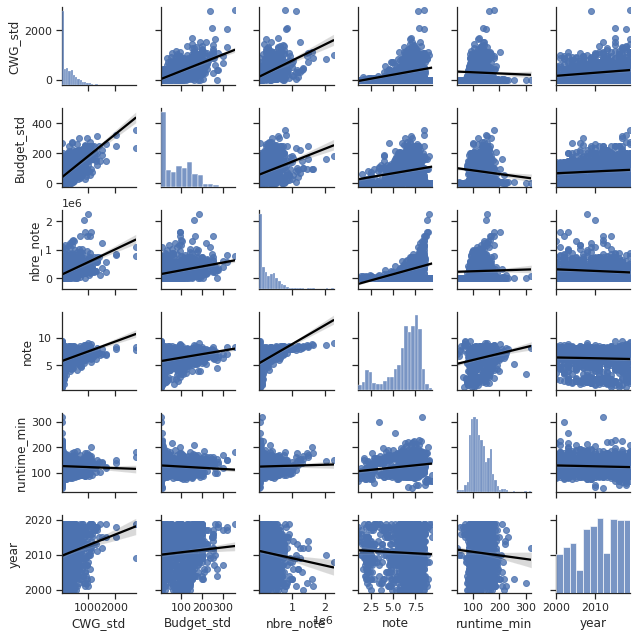

In [28]:
# Numerical analysis
col_list = ['CWG_std', 'Budget_std', 'nbre_note', 'note', 'runtime_min', 'year']
sns.pairplot(df_scale[df_scale.index.isin(ind_to_remove)], height=1.5, kind='reg', plot_kws={'line_kws':{'color':'black'}})
plt.show()

In [29]:
df_scale[df_scale.index.isin(ind_to_remove)].join(df00[['title', 'Directors']]).sample(5, random_state=6)

,CWG_std,Budget_std,nbre_note,note,runtime_min,year,genre,title,Directors
4017,418.765321,65.0,115008,5.6,145,2008,Comedy|Drama|Romance,Sex and the City,Michael Patrick
2021,603.873119,132.0,411415,6.5,116,2005,OTHER,War of the Worlds,Steven Spielberg
9636,255.429395,4.5,480311,7.7,104,2017,Horror|Mystery|Thriller,Get Out,Jordan Peele
853,522.657936,80.0,250382,6.3,115,2004,Comedy|Romance,Meet the Fockers,Jay Roach
6303,877.244782,95.0,189029,6.6,88,2012,Adventure|Animation|Comedy,Ice Age: Continental Drift,Steve Martino|Mike Thurmeier


The movies that are the most influencial seems to be those with for which there are a large difference between
the revenue and the budget. <br>

A typical exemple is the horror movie [Anabelle Creation](https://www.imdb.com/title/tt5140878/) (at the 
second line) its profit is almost 20 times greater than its budget.

In [30]:
ols_summary_fct(
    dfo=pd.get_dummies(df_scale[df_scale.index.isin(ind_to_remove)], columns=['genre'], drop_first=True),
    name_y='CWG_std',
    summary=False, graph=False
)


R2_adj: 60.8%

LOG-LIKELIHOOD:  -6.33e+03

Fscore:  12.9

Fpvalue:  0.0

AIC:  1.29e+04

BIC:  1.35e+04

CONDITION NUMBER:  1.57e+08

RESIDUAL MSE:  47808.5

HOMOSCEDASTICITY ASSUMPTION
Breush-Paga test:	Fscore:1.1, Pval=0.2

INDEPENDENCY ASSUMPTION
Autocorrelation of the first order:
The Durbin-Watson test result: 1.9

NON-COLINEARITY ASSUMPTION
                                      VIF
year                           178.851947
note                            30.350290
runtime_min                     29.323477
genre_OTHER                     17.580559
genre_Action|Adventure|Sci-Fi   13.937224
...                                   ...
genre_Drama|Romance|War          1.148013
genre_Thriller                   1.147845
genre_Comedy|Crime|Romance       1.147429
genre_Crime                      1.147399
genre_Drama|Sci-Fi               1.147365

[122 rows x 1 columns]


##### Movie to consider 

In [31]:
df_scale.drop(index=ind_to_remove).groupby('genre')['Budget_std'].count().sort_values().head(5)

genre
Adventure|Drama|Fantasy     9
Action|Drama|Sci-Fi        10
Action|Sci-Fi              10
Drama|Sci-Fi|Thriller      12
Action|Adventure           13
Name: Budget_std, dtype: int64

In [32]:
ind_to_remove = df_infl_rem.index

ols_summary_fct(pd.get_dummies(df_scale.drop(index=ind_to_remove), columns=['genre'], drop_first=True), name_y='CWG_std', summary=False, graph=False)


R2_adj: 74.0%

LOG-LIKELIHOOD:  -4.64e+04

Fscore:  212.9

Fpvalue:  0.0

AIC:  9.31e+04

BIC:  9.41e+04

CONDITION NUMBER:  2.36e+07

RESIDUAL MSE:  603.8

HOMOSCEDASTICITY ASSUMPTION
Breush-Paga test:	Fscore:29.1, Pval=0.0

INDEPENDENCY ASSUMPTION
Autocorrelation of the first order:
The Durbin-Watson test result: 2.0

NON-COLINEARITY ASSUMPTION
                                      VIF
year                           315.516176
runtime_min                     55.523595
note                            52.225034
genre_OTHER                     31.276625
genre_Drama                     27.355359
...                                   ...
genre_Action|Adventure           1.309740
genre_Drama|Sci-Fi|Thriller      1.288180
genre_Action|Sci-Fi              1.242084
genre_Action|Drama|Sci-Fi        1.240037
genre_Adventure|Drama|Fantasy    1.215529

[135 rows x 1 columns]


Number of observations:10060

R2_adj: 73.9%

LOG-LIKELIHOOD:  -4.64e+04

Fscore:  216.3

Fpvalue:  0.0

AIC:  9.31e+04

BIC:  9.41e+04

CONDITION NUMBER:  1.04e+07

RESIDUAL MSE:  606.6

HOMOSCEDASTICITY ASSUMPTION
Breush-Paga test:	Fscore:29.5, Pval=0.0

INDEPENDENCY ASSUMPTION
Autocorrelation of the first order:
The Durbin-Watson test result: 2.0


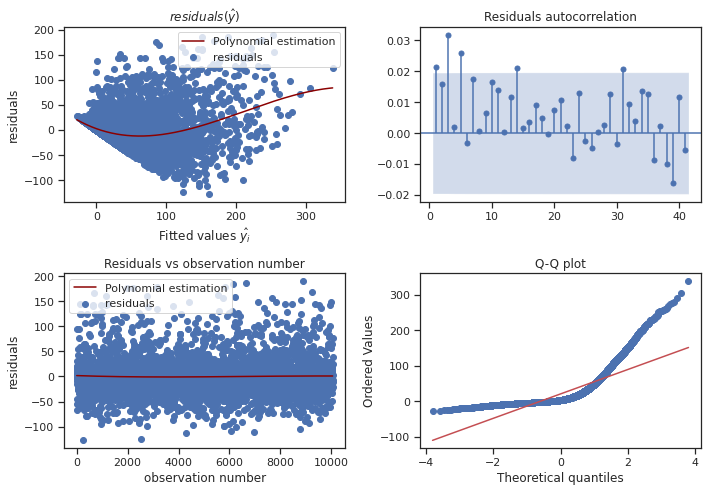


NON-COLINEARITY ASSUMPTION
                                          VIF
Budget_std                           2.681284
nbre_note                            2.043595
genre_Adventure|Animation|Comedy     1.075827
genre_OTHER                          1.072622
genre_Action|Adventure|Comedy        1.040247
...                                       ...
genre_Romance                        1.000051
genre_Musical                        1.000027
genre_Biography|Documentary|History  1.000007
genre_Documentary|Sport              1.000004
genre_Biography|Documentary          1.000003

[132 rows x 1 columns]


In [33]:
ind_to_remove = df_infl_rem.index
df_scale_2 = pd.get_dummies(df_scale.drop(index=ind_to_remove,
    columns=['year', 'note', 'runtime_min']), columns=['genre'], drop_first=True)
print(f'Number of observations:{df_scale_2.shape[0]}')
ols_summary_fct(df_scale_2, name_y='CWG_std', summary=False, size=(10, 7))

For Ridge(alpha=13) we have MSE:-617 +-34
For Ridge(alpha=13) we have R^2:73.2 +-1.4
The above results are estimated by cross_validate() and may slightly differ from those estimated by GridSearchCV()


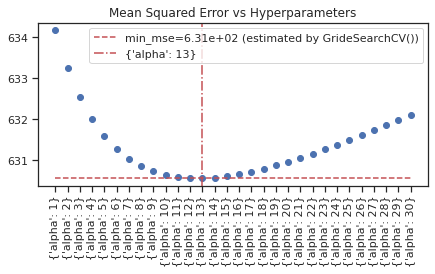

Elapsed time: 0h 0min 3s


In [34]:
hyper_params_ridge = find_bestHyperparameters(
    df=df_scale_2,
    name_y='CWG_std',
    estimator=linear_model.Ridge(),
    parameters={'alpha':np.arange(1, 31)},
    n_jobs=6
)

For Lasso(alpha=0.01) we have MSE:-617 +-34
For Lasso(alpha=0.01) we have R^2:73.2 +-1.4
The above results are estimated by cross_validate() and may slightly differ from those estimated by GridSearchCV()


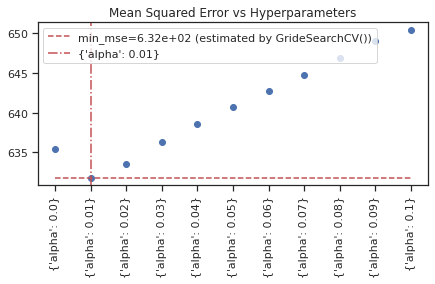

Elapsed time: 0h 0min 5s


In [35]:
hyper_params_lasso = find_bestHyperparameters(
    df=df_scale_2,
    name_y='CWG_std',
    estimator=linear_model.Lasso(),
    parameters={'alpha':np.linspace(0, .1, 11)},
    n_jobs=6
)

The model where influential observations are removed is clearly the best one.
After this removed the following predictor "year", "runtime_min" and "note".

In [36]:
y_scale_2 = df_scale_2.iloc[:, 0]
X_scale_2 = df_scale_2.iloc[:, 1:]

model_ols = sm.OLS(y_scale_2, sm.add_constant(X_scale_2))
result_ols = model_ols.fit()

result_as_html = result_ols.summary().tables[1].as_html()
result_as_frame = pd.read_html(result_as_html, header=0, index_col=0)[0]

result_as_frame['|coef|'] = np.abs(result_as_frame['coef'])
result_as_frame[result_as_frame['P>|t|']<=.1].sort_values(by='|coef|', ascending=False).round(1).head(6)

,coef,std err,t,P>|t|,[0.025,0.975],|coef|
genre_Action|Adventure|Horror,33.3,7.8,4.3,0.0,18.0,48.7,33.3
genre_Adventure|Comedy|Family,31.4,5.4,5.9,0.0,20.9,41.9,31.4
genre_Animation|Comedy|Family,29.6,6.6,4.5,0.0,16.7,42.5,29.6
genre_Action|Adventure|Thriller,28.8,7.1,4.1,0.0,14.9,42.7,28.8
genre_Action|Sci-Fi|Thriller,-25.9,6.2,-4.2,0.0,-38.1,-13.7,25.9
genre_Adventure|Animation|Comedy,25.4,4.4,5.7,0.0,16.7,34.1,25.4


From this model we observe that compared with the "Action" genre, the genre "Action|Adventure|Thriller" is 
the more attractive with an increase in the revenues of \\$ $38.7M$ in average. Contrariwise the less 
interesting genre compared to the "Action" genre is the "Action|Sci-Fi|Thriller" genre, with a decrease of 
\\$ $26.5M$.<br>


In [37]:
df_scale[(df_scale.genre=="Action|Adventure|Thriller") & (~df_scale.index.isin(ind_to_remove))].join(
    df00[['title']]).round(1).head(8)

,CWG_std,Budget_std,nbre_note,note,runtime_min,year,genre,title
161,128.9,65.0,72818,6.4,130,2000,Action|Adventure|Thriller,Space Cowboys
780,11.0,40.0,5306,4.5,93,2002,Action|Adventure|Thriller,Extreme Ops
908,277.4,70.0,172100,5.9,124,2002,Action|Adventure|Thriller,xXx
916,0.0,2.4,88,5.2,95,2004,Action|Adventure|Thriller,Bandido
3350,17.1,33.4,13342,6.5,108,2008,Action|Adventure|Thriller,The Heir Apparent: Largo Winch
5150,346.1,85.0,84205,5.2,107,2017,Action|Adventure|Thriller,xXx: Return of Xander Cage
5246,274.5,80.0,322719,6.5,103,2010,Action|Adventure|Thriller,The Expendables
5267,14.4,25.9,7493,6.2,114,2011,Action|Adventure|Thriller,Largo Winch II


The "Action|Adventure|Thriller" genre is worth thanks to movies like [Mission: Impossible II](https://www.imdb.com/title/tt0120755/) or more recently
[xXx: Return of Xander](#https://www.imdb.com/title/tt1293847/).
Nonetheless a few movies fail to make large profit like [Largo Winch](#https://www.imdb.com/title/tt0808339/), besides
we can observe that the most part of movies that fail to achieve good revenues are the movie with a 'low' 
budget here lower than $\$35M$. We could emit the hypothesis that this genre of movie is associated with
spectacular movie scenes, and viewers go to the cinema to enjoy these kind of scene, and low budget cannot 
spend lot of money these scenes which are particularly expensive: [examples](https://www.cinelinx.com/movie-news/movie-stuff/the-ten-most-expensive-action-scenes-in-film-so-far/).

In [38]:
df_scale[(df_scale.genre=="Action|Sci-Fi|Thriller") & (~df_scale.index.isin(ind_to_remove))].join(
    df00[['title']]).round(2).tail(5)

,CWG_std,Budget_std,nbre_note,note,runtime_min,year,genre,title
9172,0.01,1.60,10233,5.7,88,2016,Action|Sci-Fi|Thriller,Beta Test
9362,0.02,6.00,1467,3.0,88,2016,Action|Sci-Fi|Thriller,The Perfect Weapon
9475,0.01,22.40,1878,4.2,91,2016,Action|Sci-Fi|Thriller,WEAPONiZED
9820,0.14,12.51,2978,6.3,154,2016,Action|Sci-Fi|Thriller,Iru Mugan
10327,16.71,5.00,153341,7.5,100,2018,Action|Sci-Fi|Thriller,Upgrade


In "Action|Sci-Fi|Thriller" genre many movies have been released at loss, in the previous data the more 
significant movie is [WEAPONiZED](#https://www.imdb.com/title/tt4776564/) 

In [39]:
genre_list = [k.split('_')[1] for k in result_as_frame[result_as_frame['P>|t|']<=.05].index if k.split('_')[0]=='genre']
df_sc = df_scale[(df_scale.genre.isin(genre_list)) & (~df_scale.index.isin(ind_to_remove))].copy()

df_sc.groupby('genre')[['CWG_std', 'Budget_std']].describe().round(1).sort_values(by=[('Budget_std', '50%'), ('CWG_std', '50%')])

CWG_std                                        \
                             count   mean    std  min   25%   50%    75%   
genre                                                                      
Comedy|Family                 56.0   35.8   59.3  0.0   0.6   5.9   43.8   
Comedy|Romance               339.0   32.1   61.2  0.0   0.4   2.5   31.7   
Horror|Mystery|Thriller      106.0   38.8   53.5  0.0   1.4  13.4   59.2   
Horror|Mystery                38.0   59.3   68.7  0.0   1.0  40.7   95.6   
Drama|Music|Romance           37.0   33.0   48.2  0.0   0.2   6.8   62.1   
Adventure|Comedy|Drama        39.0   41.5   64.5  0.0   0.3   7.7   59.9   
Crime|Drama|Mystery          109.0   19.3   32.8  0.0   0.7   4.5   24.3   
Action|Crime|Drama           211.0   17.4   27.7  0.0   0.3   4.7   18.8   
Action|Adventure|Family       19.0   61.6  102.8  0.0   1.3   8.5   70.5   
Biography|Crime|Drama         55.0   24.8   38.4  0.0   0.9   9.4   42.2   
Drama|Fantasy|Mystery         21.0   16.6   25.3  0.0   0.2   1.0   23.9   
Action|Adventure|Animation    41.0   47.6   71.6  0.0   2.4  16.4   68.3   
Drama|Mystery|Romance         30.0   20.4   33.0  0.0   0.4   4.0   22.3   
Action|Drama|History          55.0   21.7   33.6  0.0   0.9   6.6   23.7   
Action|Crime|Thriller        122.0   43.7   71.5  0.0   0.6  12.4   49.6   
Action|Sci-Fi|Thriller        25.0   34.1   44.0  0.0   0.1  18.4   48.9   
Biography|Drama|Sport         41.0   31.4   57.5  0.0   2.5   6.7   38.5   
Animation|Comedy|Family       21.0   84.8  138.4  0.1   1.0   4.7   81.5   
Comedy|Sci-Fi                 15.0   32.7   36.7  0.0   0.4  14.1   66.5   
Adventure|Comedy|Family       43.0   75.0   81.9  0.0   2.5  53.0  117.4   
Action|Adventure|Thriller     17.0  109.7  125.0  0.0  11.0  72.6  214.7   
Action|Adventure|Horror       13.0   97.7  109.5  0.1   1.1  64.6  155.7   
Adventure|Animation|Comedy   124.0   79.7   91.3  0.0   8.1  44.7  117.5   
Comedy|Family|Fantasy         30.0   88.6   71.3  0.0  24.1  79.9  153.5   

                                  Budget_std                               \
                              max      count  mean   std  min   25%   50%   
genre                                                                       
Comedy|Family               242.8       56.0  13.6  16.3  0.2   1.7   4.7   
Comedy|Romance              371.6      339.0  12.5  16.9  0.0   1.5   4.8   
Horror|Mystery|Thriller     255.2      106.0   8.8  11.2  0.1   2.0   5.0   
Horror|Mystery              249.3       38.0  11.2  13.7  0.0   2.1   5.0   
Drama|Music|Romance         159.3       37.0  11.2  13.4  0.2   1.8   5.5   
Adventure|Comedy|Drama      212.9       39.0  14.3  17.0  0.1   2.7   7.2   
Crime|Drama|Mystery         186.0      109.0  15.2  14.7  0.0   3.7  10.0   
Action|Crime|Drama          155.2      211.0  15.5  16.2  0.2   3.8  10.0   
Action|Adventure|Family     335.3       19.0  32.2  32.7  0.4   3.1  10.0   
Biography|Crime|Drama       214.1       55.0  17.2  19.1  0.2   3.0  10.0   
Drama|Fantasy|Mystery        84.3       21.0  17.8  21.3  0.2   2.0  11.0   
Action|Adventure|Animation  375.5       41.0  21.2  24.9  0.1   4.0  11.0   
Drama|Mystery|Romance       131.0       30.0  17.6  15.9  0.0   2.5  13.0   
Action|Drama|History        138.3       55.0  21.0  20.2  0.4   6.1  13.5   
Action|Crime|Thriller       342.5      122.0  23.0  22.6  0.8   5.0  17.0   
Action|Sci-Fi|Thriller      173.9       25.0  25.2  21.2  1.6   8.0  17.0   
Biography|Drama|Sport       309.2       41.0  19.4  12.7  0.6   9.0  18.6   
Animation|Comedy|Family     462.0       21.0  29.4  34.8  0.4   3.2  20.0   
Comedy|Sci-Fi                98.4       15.0  26.9  27.1  0.1   3.7  20.0   
Adventure|Comedy|Family     282.4       43.0  29.5  26.2  1.0   5.0  20.0   
Action|Adventure|Thriller   346.1       17.0  40.8  33.3  2.4  13.0  25.9   
Action|Adventure|Horror     312.3       13.0  27.6  22.0  1.3   9.0  30.0   
Adventure|Animation|Comedy  384.3      124.0  36.

The relationship between Budgert and CWG being linear we can make a rough approximation, and then considering
that CWG_std percentiles correspond to Budget_std percentiles.

The above table is interesting it presents the many information to summarize information of [Budget_std](#Budget_std) and [CWG_std](#CWG_std). </br>
I sorted this table by the median of the variable Budget_std to identify what is for low budget with a
median of $\$5M$ the most interesting Budget_std value.</br> 
It seems that the genre **'Drama|Horror|Mystery'** is the best for a $50%$ of the data the budget is between $0$
and $5M$ nonetheless this budget range does not make lot of money, if you are in the $25%$ of the lower budget
values ($\$0.1M$-$\$01.8M$) you will may be losing.</br>
But the interesting things appear when you are above the first half of the budget values meaning $\$5M$ then 
you will earn almost $\$7M$. And IF you pass the thresh of the $75%$ of the budget values meaning $\$10M$ you
earn almost $\$56M$ that is more than $5$ times greater that the money invested!! </br> 
Even the very attractive Action|Adventure|Thriller genre cannot multiply the Budget value as well, but it
seems the best for large budget meaning approximately $\$70M$, then you can earn 3 times your budget. 

#### Log Transformation

We have removed: 1205 observations.

R2_adj: 69.3%

LOG-LIKELIHOOD:  -1.90e+04

Fscore:  168.1

Fpvalue:  0.0

AIC:  3.84e+04

BIC:  3.93e+04

CONDITION NUMBER:  1.32e+07

RESIDUAL MSE:  2.9

HOMOSCEDASTICITY ASSUMPTION
Breush-Paga test:	Fscore:5.6, Pval=0.0

INDEPENDENCY ASSUMPTION
Autocorrelation of the first order:
The Durbin-Watson test result: 2.0
{'rmse': {'mean': 369008604.1, 'std': 86980302.5}, 'r2': {'mean': -1492.5, 'std': 753.5}}


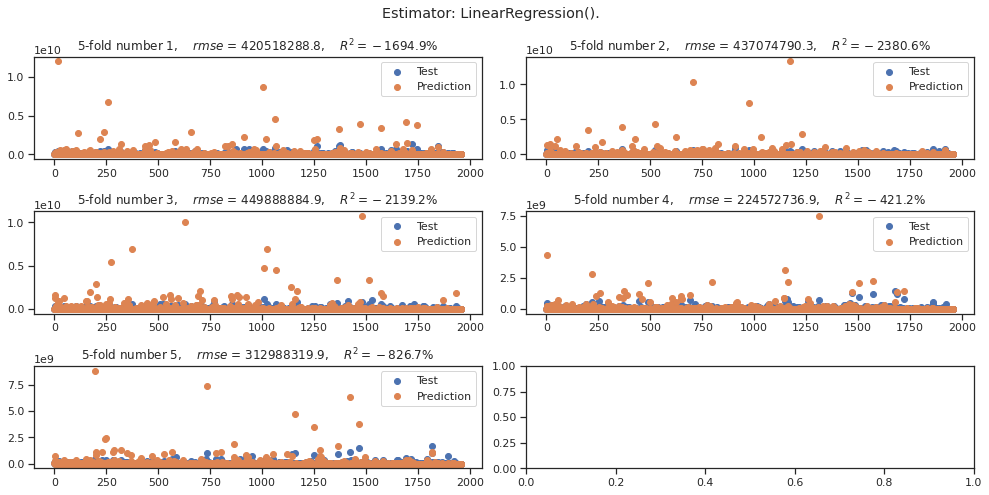

Elapsed time: 0h 0min 1s


{'rmse': {'mean': 369008604.1, 'std': 86980302.5},
 'r2': {'mean': -1492.5, 'std': 753.5}}

In [40]:
df_log = df.copy()
df_log.loc[:, ['CWG_std', 'Budget_std']] = np.log(df_log.loc[:, ['CWG_std', 'Budget_std']]) # scaling  evaluating the efficiency of log-transformation.


y_log, X_log = df_log.iloc[:, 0], df_log.iloc[:, 1:-1]
result_ols_log = sm.OLS(y_log, X_log).fit()

infl_log = OLSInfluence(result_ols_log)

df_infl_log = pd.DataFrame(dict(
    hat_diag = infl_log.hat_matrix_diag,
    resid = sci.zscore(infl_log.resid)),
    index = infl_log.results.model.data.row_labels                  
).sort_values(by='hat_diag', ascending=False)

highLever = 2*(result_ols_log.df_model+1)/result_ols_log.nobs

alpha = .05
cutoff = sci.norm.ppf(1-alpha/2)

df_infl_log_rem = df_infl_log[(df_infl_log.hat_diag>highLever) | (np.abs(df_infl_log.resid)>cutoff)
                     ].sort_values(by='hat_diag', ascending=False)
ind_to_remove = df_infl_log_rem.index
print(f"We have removed: {df_infl_log_rem.shape[0]} observations.")
df_infl_log_rem.head()

ind_to_remove_log = df_infl_log_rem.index

df_log_2 = pd.get_dummies(df_log.drop(index=ind_to_remove_log, columns=['year', 'runtime_min', 'note']), columns=['genre'], drop_first=True)
ols_summary_fct(df_log_2, name_y='CWG_std', summary=False, graph=False, vif=False)

compute_rmse_r2(df_log_2, name_y='CWG_std', fct=lambda x: np.exp(x), size=(14, 7))

Log transformation is not very interesting because with large values it make excessive estimation an this give us a poor model.
This last test allow me to present the [compute_rmse_r2](#analyticalFunctions.py#L739) function.

### 3.3 Prediction
<a id='prediction'></a>

In this part I will focus, on the prediction, then I will be concerned to minimize the mean squared error
estimate provided by cross validations.
This time I will not use the dummy code for the genre variable but simply the integer coding, this has some advantages,
a priori we should use all the available genre combinations alike the previous modeling and we can make theoretically all the mixed genre that we want.

In [41]:
## Genres
# Dummies Genre
df01 = df0[(df0.Budget>=7.5e4) & (df0.Budget<=5e8)].drop(
    columns=['country', 'Budget', 'Cumulative_Worldwide_Gross_curr',
                 'Cumulative_Worldwide_Gross']).copy()
df01.to_csv('../2_data/2_transformed/2_data_reducedBudget', sep=';', index=False)
col_ref = 'Drama' 
# dummyFrame = frame["genre"].str.get_dummies().drop(columns=col_ref)   # Dummy table creation from a serie containing strings of words seperated by a comma.
dummyFrame = frame["genre"].str.get_dummies()   # Dummy table creation from a serie containing strings of words seperated by a comma.
df = df01.join(dummyFrame)
df.to_csv('../2_data/2_transformed/2_dataWithoutDecorrelation.csv',
          sep=';', index=False)

In [42]:
df00 = pd.read_csv("../2_data/2_transformed/2_dataWithoutDecorrelation.csv",
                  sep=";")
#------------------------------------------------------------------------------
df = df00.select_dtypes('number').dropna().copy()
col_order = list(df)
col_order.insert(0, col_order.pop(col_order.index("CWG_std")))
col_order.remove('note')
col_order.remove('nbre_note')

In [43]:
df_scale_pred = df.loc[:, col_order]
df_scale_pred.loc[:, ['Budget_std', 'CWG_std']] =\
    df_scale_pred.loc[:, ['Budget_std', 'CWG_std']]*1e-6            # a scaling to have the money amount in millions of US dollars.
y_scale_pred, X_scale_pred = df_scale_pred.iloc[:, 0], df_scale_pred.iloc[:, 1:]

We will remove the leverages points

I removed 'nbre_note' and 'note' variables because they are not variables on which anybody can control.
I have also observed that the once the 2 previous variables were removed, the 'runtime_min' variable did not
help to decrease the mean squared so I decided to also remove  'runtime_min' variable.

#### inear Regression

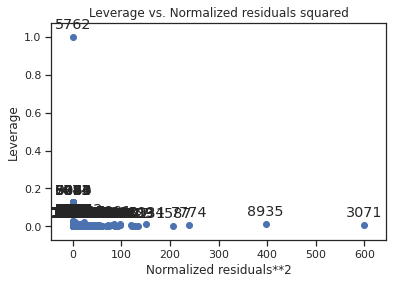

In [44]:
result_ols_pred = sm.OLS(y_scale_pred, X_scale_pred).fit()
sm.graphics.plot_leverage_resid2(result_ols_pred)
plt.show()

In [45]:
infl_pred = OLSInfluence(result_ols_pred)

df_infl_pred = pd.DataFrame(dict(
    hat_diag = infl_pred.hat_matrix_diag,
    resid = sci.zscore(infl_pred.resid)),
    index = infl_pred.results.model.data.row_labels                  
).sort_values(by='hat_diag', ascending=False)

highLever = 2*(result_ols_pred.df_model+1)/result_ols_pred.nobs

alpha = .05
cutoff = sci.norm.ppf(1-alpha/2)

df_infl_pred_rem = df_infl_pred[(df_infl_pred.hat_diag>highLever) | (np.abs(df_infl_pred.resid)>cutoff)
                     ].sort_values(by='hat_diag', ascending=False)
ind_to_remove_pred = df_infl_pred_rem.index
print(df_infl_pred_rem.shape)
df_infl_pred_rem.head()

(1072, 2)


,hat_diag,resid
5762,1.000000,0.000258
6883,0.126021,0.101765
5084,0.126006,0.024062
9060,0.126003,0.051032
3043,0.125450,0.345005


In [46]:
df_scale_pred_2 = df_scale_pred.drop(index=ind_to_remove_pred)
ols_summary_fct(df_scale_pred_2, name_y='CWG_std', graph=False)

                            OLS Regression Results                            
Dep. Variable:                CWG_std   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     1414.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        11:10:18   Log-Likelihood:                -47763.
No. Observations:                9638   AIC:                         9.557e+04
Df Residuals:                    9615   BIC:                         9.574e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1118.9343    140.160     -7.983      

/home/kr/miniconda3/envs/1_dataScience/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


                            OLS Regression Results                            
Dep. Variable:                CWG_std   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1537.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        11:10:19   Log-Likelihood:                -47809.
No. Observations:                9638   AIC:                         9.566e+04
Df Residuals:                    9617   BIC:                         9.581e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.8118      1.193     -4.035      

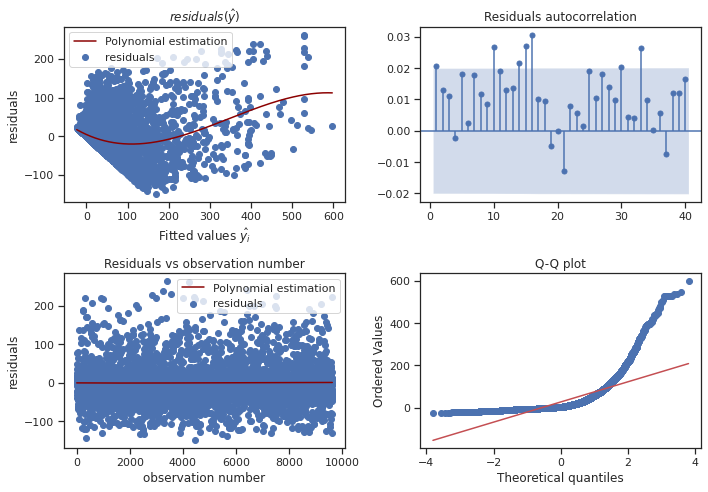


NON-COLINEARITY ASSUMPTION
                  VIF
Budget_std   1.726540
Drama        1.584572
Adventure    1.558939
Action       1.524090
Comedy       1.341862
Crime        1.320790
Thriller     1.279180
Romance      1.278931
Animation    1.228824
Horror       1.215938
Mystery      1.194472
Biography    1.156241
Family       1.118709
History      1.115563
Sci-Fi       1.106389
Fantasy      1.104917
Music        1.053365
Sport        1.013017
Documentary  1.012842
War          1.009836


In [47]:
df_scale_pred_2 = df_scale_pred.drop(index=ind_to_remove_pred, 
    columns=['runtime_min', 'year', 'Musical', 'News', 'Short', 'Western'])
ols_summary_fct(df_scale_pred_2, name_y='CWG_std')

{'rmse': {'mean': 34.6, 'std': 1.0}, 'r2': {'mean': 75.9, 'std': 1.4}}


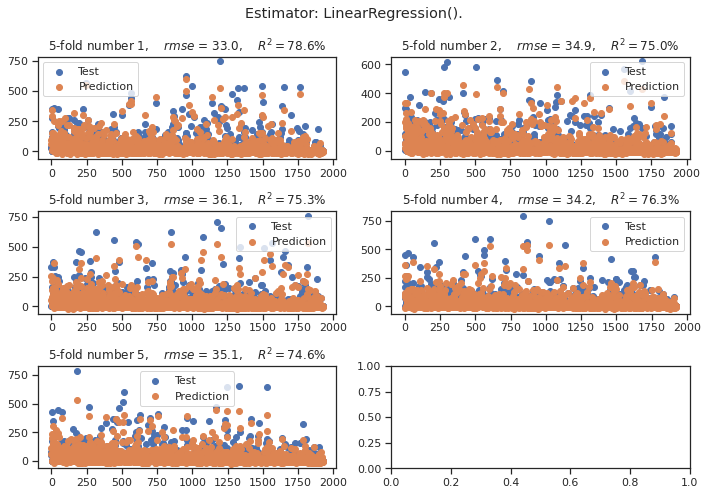

Elapsed time: 0h 0min 1s


{'rmse': {'mean': 34.6, 'std': 1.0}, 'r2': {'mean': 75.9, 'std': 1.4}}

In [48]:
compute_rmse_r2(
    dfo = df_scale_pred_2,
    name_y = 'CWG_std',
    estimator= linear_model.LinearRegression()
)

I We have seen that the relationship is rather linear, the OLS seem to be the best suited model, maybe we 
could have some improvement with non-parametric methods.

/home/kr/miniconda3/envs/1_dataScience/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


For RandomForestRegressor(n_estimators=350) we have MSE:-1299 +-63
For RandomForestRegressor(n_estimators=350) we have R^2:74.0 +-1.7
The above results are estimated by cross_validate() and may slightly differ from those estimated by GridSearchCV()


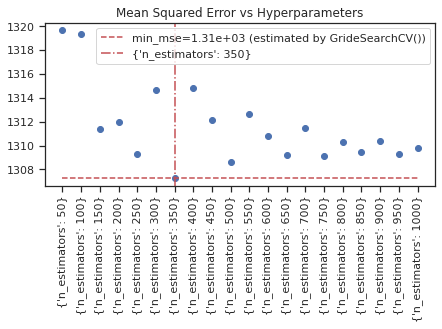

Elapsed time: 0h 4min 40s


In [49]:
best_hyperparams_adaboost = find_bestHyperparameters(
    estimator=RandomForestRegressor(),
    df=df_scale_pred_2,
    name_y = 'CWG_std',
    parameters={'n_estimators':np.arange(0, 1001, 50)[1:]},
    n_jobs=6
)

The famous method random forest needs nearly 900 n_estimators, is too complex. <br>
A good idea could be using KNN method.

For KNeighborsRegressor(n_neighbors=28) we have MSE:-1097 +-47
For KNeighborsRegressor(n_neighbors=28) we have R^2:78.0 +-1.0
The above results are estimated by cross_validate() and may slightly differ from those estimated by GridSearchCV()


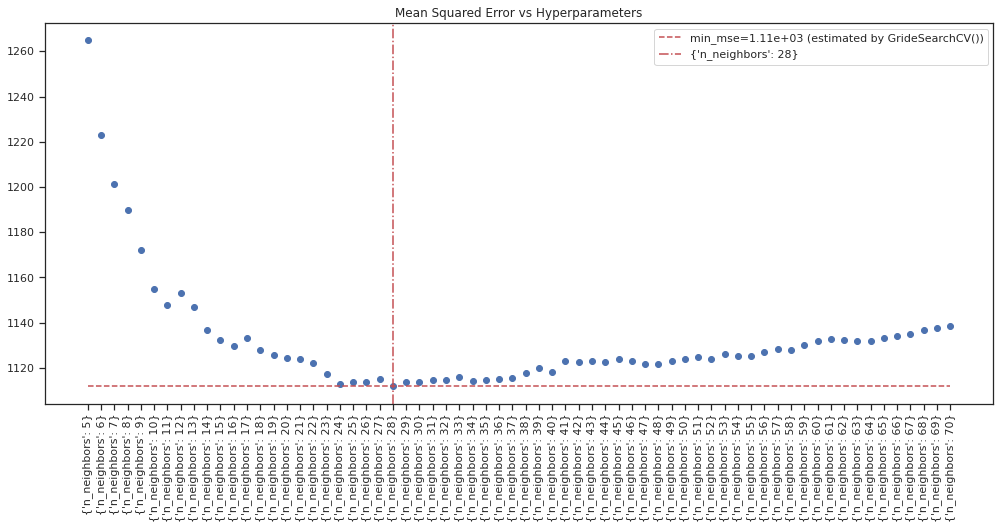

Elapsed time: 0h 0min 12s


In [50]:
best_hyperparams_adaboost = find_bestHyperparameters(
    estimator=KNeighborsRegressor(),
    df=df_scale_pred_2,
    name_y = 'CWG_std',
    parameters={'n_neighbors':np.arange(5, 71)},
    size=(17, 7),
    n_jobs=6
)

KNN needs 24 neighbors, it the complexity of this method is largely more interesting than for Random Forest.
It is true that with 28 neighbors we get the lower MSE score, but removing 4 neighbors does not really change
the things, and we reduce the complexity of the model.

{'rmse': {'mean': 33.1, 'std': 0.7}, 'r2': {'mean': 78.1, 'std': 1.0}}


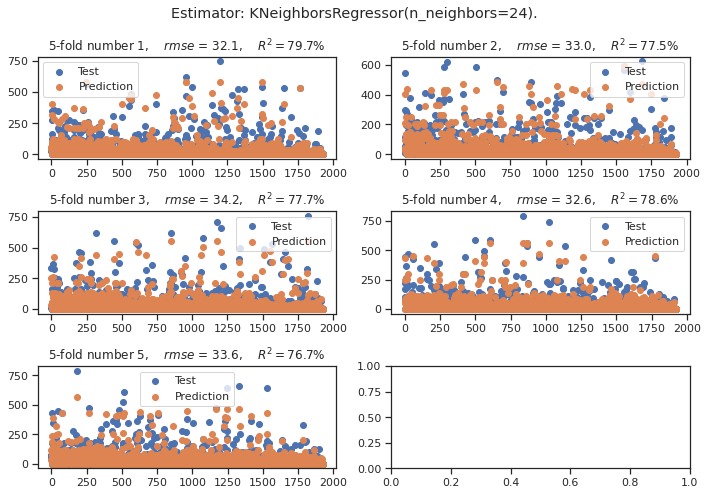

Elapsed time: 0h 0min 2s


{'rmse': {'mean': 33.1, 'std': 0.7}, 'r2': {'mean': 78.1, 'std': 1.0}}

In [51]:
compute_rmse_r2(
    dfo = df_scale_pred_2,
    name_y = 'CWG_std',
    estimator= KNeighborsRegressor(n_neighbors=24)
)

The prediction is slightly better and provides a more stable $R^{2}$, this algorithm will be retained.

## 4 Another avenue for future research.

If one day I resume this project I will go further with a similar model such as the following one, because it take account of the  actors, directors.

In [52]:
def listGenre(row):
    genre_list = row.split('|')
    diff = 3 - len(genre_list)
    if diff:
        genre_list += ['' for k in range(diff)]
    return genre_list

def extractingGenre(row, i):
    if i<0 or i>2:
        print('We must have 0<=i<=2.')
        return np.nan
    
    genre_list = row.split('|')
    diff = 3 - len(genre_list)
    if diff:
        genre_list += ['not_filled' for k in range(diff)]
    return genre_list[i]

In [53]:
def firstElem(row, L):
    if row != np.nan:
        L.append(row[0].strip())
        
def firstElem_fct(row):
    if row != np.nan:
        return(row[0].strip())
    
def length_fct(row):
    length = 0
    if row != np.nan:
        length = len(row)
    return(length)

def genre_fct(row, j):
    if len(row) >= j:
        r = row[j-1].strip()
    else:
        r = ''
    return r

In [54]:
df_2 = df0.drop(columns=['title', 'Cumulative_Worldwide_Gross_curr', 'Budget',
                         'Cumulative_Worldwide_Gross', 'year', 'note',
                          'nbre_note','runtime_min'])

dct_col = {'Director': [1, 2], 'Writer':[1, 2], 'Star':[1, 2, 3]}
names = []
for k in dct_col:
    for j in dct_col[k]:
        name =  k + 's'
        if name == 'genres':
            name = k
        df_2[k+'_'+str(j)] = df_2[name].fillna('').str.split('|').apply(genre_fct, j=j)
        names.append(name)       
s = pd.get_dummies(df_2.genre, drop_first=True).sum().sort_values(ascending=False)
L = ['genre', 'Director_1', 'Writer_1', 'Star_1']
count_set = {k:pd.get_dummies(df_2[k], drop_first=True).sum().sort_values(ascending=False) for k in L}
df_2 = pd.get_dummies(df_2, columns=L)

threshs = {'Director_1':20, 'Writer_1': 20, 'Star_1':20, 'genre':50}

other_set = {k:list(count_set[k][count_set[k]<threshs[k]].index) for k in L}
other_set = {k:[k+'_'+item for item in other_set[k]] for k in L}

for k in L:
    df_2.loc[:, 'other_'+k] = df_2.loc[:, other_set[k]].sum(1)
    df_2.drop(columns=other_set[k], inplace=True)

cols = list(df_2)
cols.insert(0, cols.pop(cols.index('CWG_std')))
df_2 = df_2.loc[:, cols].select_dtypes('number').copy()

In [55]:
df_2.head()

,CWG_std,Budget_std,genre_Action,genre_Action|Adventure|Animation,genre_Action|Adventure|Comedy,genre_Action|Adventure|Drama,genre_Action|Adventure|Fantasy,genre_Action|Adventure|Sci-Fi,genre_Action|Comedy,genre_Action|Comedy|Crime,...,Star_1_Matt Damon,Star_1_Matthew McConaughey,Star_1_Nicolas Cage,Star_1_Nicole Kidman,Star_1_Robert De,Star_1_Will Ferrell,other_genre,other_Director_1,other_Writer_1,other_Star_1
0,76019048.0,48000000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
1,49666.0,10000000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
2,5271666.0,22000000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
3,15927.0,120000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
4,224834564.0,45000000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1


In [56]:
result_ols_2 = sm.OLS(df_2.iloc[:, 0], df_2.iloc[:, 1:]).fit()
infl_2 = OLSInfluence(result_ols)

df_infl_2 = pd.DataFrame(dict(
    hat_diag = infl_2.hat_matrix_diag,
    resid = sci.zscore(infl_2.resid)),
    index = infl_2.results.model.data.row_labels                  
).sort_values(by='hat_diag', ascending=False)

highLever = 2*(result_ols.df_model+1)/result_ols.nobs

alpha = .05
cutoff = sci.norm.ppf(1-alpha/2)

df_infl_2_rem = df_infl_2[(df_infl_2.hat_diag>highLever) | (np.abs(df_infl_2.resid)>cutoff)
                     ].sort_values(by='hat_diag', ascending=False)
print(df_infl_2_rem.shape)
df_infl_2_rem.head()

(1983, 2)


,hat_diag,resid
2677,0.111431,-2.696433
7309,0.111406,-0.051694
7522,0.111220,-0.292390
10978,0.111136,0.626572
8335,0.111135,0.270584


In [57]:
ind_to_remove_2 = df_infl_2_rem.index

ols_summary_fct(dfo=df_2.drop(index=ind_to_remove_2), name_y='CWG_std', summary=False, graph=False, vif=False)


R2_adj: 23.5%

LOG-LIKELIHOOD:  -1.83e+05

Fscore:  44.4

Fpvalue:  0.0

AIC:  3.67e+05

BIC:  3.67e+05

CONDITION NUMBER:  8.87e+20

RESIDUAL MSE:  1.3385851397238036e+16

HOMOSCEDASTICITY ASSUMPTION
Breush-Paga test:	Fscore:10.7, Pval=0.0

INDEPENDENCY ASSUMPTION
Autocorrelation of the first order:
The Durbin-Watson test result: 1.9
